In [1]:
import argparse
import logging
import os
import time

import torch
import torch.nn as nn
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
import numpy as np

from pythae.data.datasets import DatasetOutput
from pythae.models import VQVAE, VQVAEConfig, VAEConfig, VAE
from pythae.models.base.base_utils import ModelOutput
from pythae.models.nn.base_architectures import BaseDecoder, BaseEncoder
from pythae.models.nn.benchmarks.utils import ResBlock
from pythae.trainers import BaseTrainer, BaseTrainerConfig
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)
console = logging.StreamHandler()
logger.addHandler(console)
logger.setLevel(logging.INFO)

PATH = os.path.dirname(os.path.abspath("."))

%matplotlib inline
%load_ext autoreload
%autoreload 2

/usr/lib/python3/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/lib/python3/dist-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
class Encoder_Conv_VAE_new_dSprites(BaseEncoder):
    def __init__(self, args):
        BaseEncoder.__init__(self)

        self.input_dim = (1, 256, 256)
        self.latent_dim = args.latent_dim
        self.n_channels = 1

        self.conv_layers = nn.Sequential(
            nn.Conv2d(self.n_channels, 32, 4, 2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 4, 2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 4, 2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 4, 2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )

        self.embedding = nn.Linear(1024, args.latent_dim)
        self.log_var = nn.Linear(1024, args.latent_dim)

    def forward(self, x: torch.Tensor):
        h1 = self.conv_layers(x).reshape(x.shape[0], -1)
        output = ModelOutput(
            embedding=self.embedding(h1),
            log_covariance=self.log_var(h1)
        )
        return output

In [3]:
class Decoder_Conv_AE_new_dSprites(BaseDecoder):
    def __init__(self, args):
        BaseDecoder.__init__(self)
        self.input_dim = (1, 256, 256)
        self.latent_dim = args.latent_dim
        self.n_channels = 1

        self.fc = nn.Linear(args.latent_dim, 256 * 2 * 2)
        self.deconv_layers = nn.Sequential(
            nn.ConvTranspose2d(256, 256, 4, 2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, 2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 128, 4, 2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, 4, 2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, self.n_channels, 4, 2, padding=1),
            nn.Sigmoid(),
        )

    def forward(self, z: torch.Tensor):
        h1 = self.fc(z).reshape(z.shape[0], 256, 2, 2)
        output = ModelOutput(reconstruction=self.deconv_layers(h1))

        return output

In [4]:
class NewDSprites(Dataset):
    def __init__(self, data_file_path=None, transforms=None):
        self.imgs_arr = np.load(data_file_path, allow_pickle=True)["imgs"]
        # if is_train:
        #     self.imgs_arr = self.imgs_arr[train_idxs, :]
        # else:
        #     self.imgs_path = self.imgs_path[60000:]
        self.transforms = transforms

    def __len__(self):
        return len(self.imgs_arr)

    def __getitem__(self, idx):
        img = np.expand_dims(self.imgs_arr[idx, :, :], axis=-1)
        if self.transforms is not None:
            img = self.transforms(img)
        return DatasetOutput(data=img)

In [5]:
img_transforms = transforms.Compose([transforms.ToTensor()])

dataset = NewDSprites(
    data_file_path="../../data/new_dSprites_256x256.npz",
    transforms=img_transforms,
)

In [6]:
model_config = VAEConfig(
    input_dim=(1, 256, 256), latent_dim=10
)

In [7]:
encoder = Encoder_Conv_VAE_new_dSprites(model_config)
decoder = Decoder_Conv_AE_new_dSprites(model_config)

In [8]:
model = VAE(model_config=model_config, encoder=encoder, decoder=decoder)

In [9]:
model

VAE(
  (decoder): Decoder_Conv_AE_new_dSprites(
    (fc): Linear(in_features=10, out_features=1024, bias=True)
    (deconv_layers): Sequential(
      (0): ConvTranspose2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU()
      (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU()
      (12): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(

In [10]:
training_config = BaseTrainerConfig(
    output_dir='conv_vae_new_dSprites_v1',
    # train_dataloader_num_workers=8,
    # eval_dataloader_num_workers=8,
    learning_rate=1e-4,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    steps_saving=None,
    # no_cuda=False,
    num_epochs=50)

In [11]:
from pythae.trainers.training_callbacks import WandbCallback

callbacks = []
wandb_cb = WandbCallback()
wandb_cb.setup(
    training_config,
    model_config=model_config,
    project_name="multimodal_llm_robustness_exp",
    entity_name="sujithvemi-Synechron",
)

callbacks.append(wandb_cb)

wandb: Currently logged in as: sujithvemi (sujithvemi-Synechron). Use `wandb login --relogin` to force relogin


In [12]:
from pythae.pipelines import TrainingPipeline
pipeline = TrainingPipeline(
model=model,
training_config=training_config)

In [9]:
last_training = sorted(os.listdir('conv_vae_new_dSprites_v2'))[-1]
print(last_training)

VAE_training_2024-07-20_08-54-53


In [33]:
from pythae.models import AutoModel

# model_rec = AutoModel.load_from_folder(os.path.join('conv_vae_new_dSprites_v1', last_training, 'final_model'))
model_rec = AutoModel.load_from_folder(os.path.join('conv_vae_new_dSprites_v2', last_training, 'checkpoint_epoch_6'))
model_rec

VAE(
  (decoder): Decoder_Conv_AE_new_dSprites(
    (fc1): Sequential(
      (0): Linear(in_features=10, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): PReLU(num_parameters=1)
    )
    (fc2): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): PReLU(num_parameters=1)
    )
    (deconv_layers): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): PReLU(num_parameters=1)
      (3): ConvTranspose2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): PReLU(num_parameters=1)
      (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2

In [27]:
from pythae.samplers import NormalSampler


sampler = NormalSampler(
    model=model_rec
)
gen_data = sampler.sample(
    num_samples=25
)

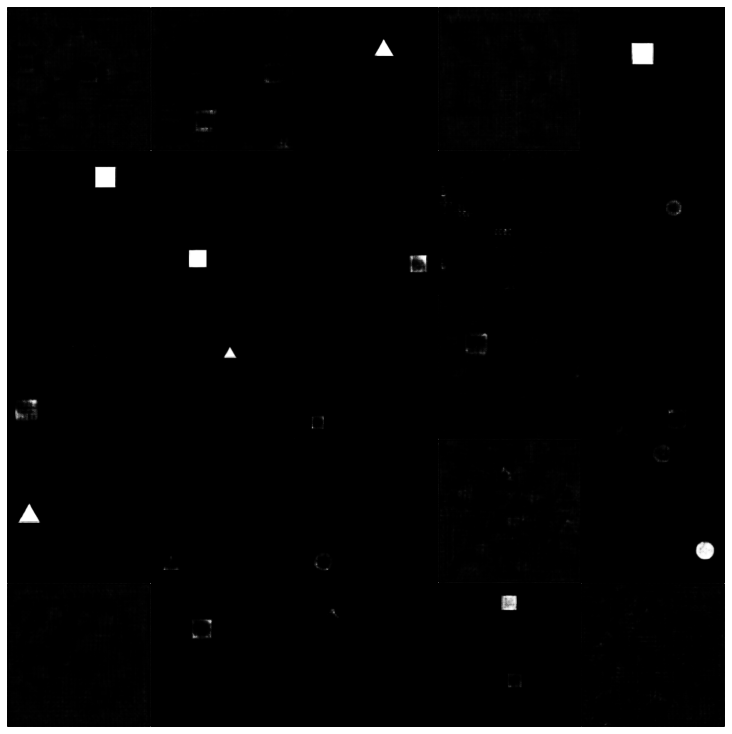

In [34]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))

for i in range(5):
    for j in range(5):
        axes[i][j].imshow(gen_data[i*5 +j].cpu().reshape(256, 256), cmap='gray')
        axes[i][j].axis('off')
plt.tight_layout(pad=0.)